In [ ]:
import os 
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments/")

In [ ]:
from functools import partial

import torch 
import torch.nn as nn
from datasets import load_dataset
from PIL import Image

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore Waterbirds

In [ ]:
import pandas as pd

dataset_dir = "datasets/waterbird_complete95_forest2water2"
# load metadata.csv
metadata = pd.read_csv(dataset_dir + "/metadata.csv")
# split into "train", "val", "test" by using "split" (0, 1, 2)
train = metadata[metadata.split == 0]
val = metadata[metadata.split == 1]
test = metadata[metadata.split == 2]
# remove "split" column
train = train.drop(columns=["split"])
val = val.drop(columns=["split"])
test = test.drop(columns=["split"])
# write new csv
train.to_csv(dataset_dir + "/train_metadata.csv", index=False)
val.to_csv(dataset_dir + "/val_metadata.csv", index=False)
test.to_csv(dataset_dir + "/test_metadata.csv", index=False)
# create split dictionary
split_dict = {"train": "train_metadata.csv", "val": "val_metadata.csv", "test": "test_metadata.csv"}

In [ ]:
dataset = load_dataset("datasets/waterbird_complete95_forest2water2", data_files=split_dict)

Generating train split: 4795 examples [00:00, 337076.81 examples/s]
Generating val split: 1199 examples [00:00, 111203.82 examples/s]
Generating test split: 5794 examples [00:00, 466391.54 examples/s]


In [ ]:
from datasets import Value
dataset.cast_column("y", Value("float32"))

Casting the dataset: 100%|██████████| 5794/5794 [00:00<00:00, 398161.67 examples/s]


DatasetDict({
    train: Dataset({
        features: ['img_id', 'img_filename', 'y', 'place', 'place_filename'],
        num_rows: 4795
    })
    val: Dataset({
        features: ['img_id', 'img_filename', 'y', 'place', 'place_filename'],
        num_rows: 1199
    })
    test: Dataset({
        features: ['img_id', 'img_filename', 'y', 'place', 'place_filename'],
        num_rows: 5794
    })
})

In [ ]:
dataset["train"]["y"][0]

1

In [ ]:
# remove image_id and place_filename from dataset
dataset = dataset.remove_columns(["img_id", "place_filename"])

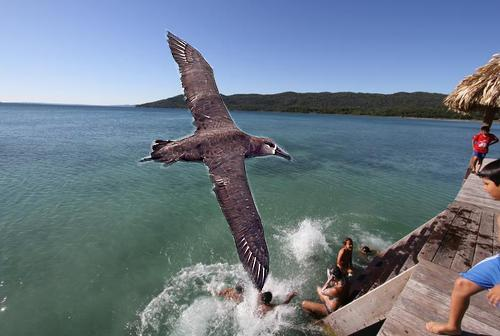

In [ ]:
img_filename = dataset["train"][0]["img_filename"]
image = Image.open(dataset_dir + "/" + img_filename)
image

In [ ]:
sum([i == j for i, j in zip(dataset["train"]["y"], dataset["train"]["place"])]) / len(dataset["train"])

0.9499478623566214

In [ ]:
# same computation for validation
sum([i == j for i, j in zip(dataset["val"]["y"], dataset["val"]["place"])]) / len(dataset["val"])

0.5004170141784821

In [ ]:
# same computation for test
sum([i == j for i, j in zip(dataset["test"]["y"], dataset["test"]["place"])]) / len(dataset["test"])

0.5

In [ ]:
# balance of labels 
sum([i == 0 for i in dataset["train"]["y"]]) / len(dataset["train"]) # use this to set auxiliary KL div loss

0.7678832116788321

# Load Resnet 50 from HF and Apply Processor to Data

In [ ]:
# load resnset50 from huggingface
from transformers import AutoImageProcessor, ResNetForImageClassification
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=0) # num labels is 0 because we are using it as a feature extractor

Some weights of the model checkpoint at microsoft/resnet-50 were not used when initializing ResNetForImageClassification: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers.models.convnext.image_processing_convnext import ConvNextImageProcessor
type(processor)

transformers.models.convnext.image_processing_convnext.ConvNextImageProcessor

In [ ]:
from transformers.models.resnet.modeling_resnet import ResNetForImageClassification
type(model)

transformers.models.resnet.modeling_resnet.ResNetForImageClassification

In [ ]:
def transform_images(examples):
    examples["pixel_values"] = [processor(Image.open(dataset_dir + "/" + img_filename).convert("RGB"), return_tensors="pt")["pixel_values"][0] for img_filename in examples["img_filename"]]
    return examples

In [ ]:
inputs = processor(image.convert("RGB"), return_tensors="pt")
with torch.no_grad():
    out = model(**inputs, output_hidden_states=True)


In [ ]:
out["logits"].shape

torch.Size([1, 2048])

In [ ]:
out["hidden_states"][-1].shape

torch.Size([1, 2048, 7, 7])

# Define DivDis Loss Function

Review: Mutual Information

Amount of information received about one random variable from observing the other random variable

determines how different joint distribution is from product of marginal distributions

Expected value of the pointwise mutual information 

KL Divergence between joint distribution and project of the marginals 

(Recall KLDiv(P, Q) = sum(P log(P/Q)))

So MI(X, Y) = KLDiv(P(X,Y)||P_X * P_Y) = sum(P(X,Y)log(P(X,Y)/P_X * P_Y))


Steps for estimating mutual information
1. compute probabilities from logits 
2. compute mean probabilities for each of (C_A=0, C_B=0), (C_A=0, C_B=1), (C_A=1, C_B=0), (C_A=1, C_B=1) across batch
3. compute marginal distribution by taking mean over both distributions independently, then taking product
4. take kl divergence between joint and product of marginals (mutual information)

In [ ]:
# from https://github.com/yoonholee/DivDis/blob/main/divdis.py
# TODO: understand this code
import torch
from einops import rearrange
from torch import nn

def to_probs(logits, heads):
    """
    Converts logits to probabilities.
    Input must have shape [batch_size, heads * classes].
    Output will have shape [batch_size, heads, classes].
    """

    B, N = logits.shape
    if N == heads:  # Binary classification; each head outputs a single scalar.
        preds = logits.sigmoid().unsqueeze(-1)
        probs = torch.cat([preds, 1 - preds], dim=-1)
    else:
        logits_chunked = torch.chunk(logits, heads, dim=-1)
        probs = torch.stack(logits_chunked, dim=1).softmax(-1)
    B, H, D = probs.shape
    assert H == heads
    return probs


class DivDisLoss(nn.Module):
    """Computes pairwise repulsion losses for DivDis.

    Args:
        logits (torch.Tensor): Input logits with shape [BATCH_SIZE, HEADS * DIM].
        heads (int): Number of heads.
        mode (str): DIVE loss mode. One of {pair_mi, total_correlation, pair_l1}.
    """

    def __init__(self, heads):
        super().__init__()
        self.heads = heads

    def forward(self, logits):
        heads = self.heads
        probs = to_probs(logits, heads)

        marginal_p = probs.mean(dim=0)  # H, D
        marginal_p = torch.einsum(
            "hd,ge->hgde", marginal_p, marginal_p
        )  # H, H, D, D
        marginal_p = rearrange(marginal_p, "h g d e -> (h g) (d e)")  # H^2, D^2

        joint_p = torch.einsum("bhd,bge->bhgde", probs, probs).mean(
            dim=0
        )  # H, H, D, D
        joint_p = rearrange(joint_p, "h g d e -> (h g) (d e)")  # H^2, D^2

        # Compute pairwise mutual information = KL(P_XY | P_X x P_Y)
        # Equivalent to: F.kl_div(marginal_p.log(), joint_p, reduction="none")
        kl_computed = joint_p * (joint_p.log() - marginal_p.log())
        kl_computed = kl_computed.sum(dim=-1)
        kl_grid = rearrange(kl_computed, "(h g) -> h g", h=heads)
        repulsion_grid = -kl_grid

        repulsion_grid = torch.triu(repulsion_grid, diagonal=1)
        repulsions = repulsion_grid[repulsion_grid.nonzero(as_tuple=True)]
        repulsion_loss = -repulsions.mean()

        return repulsion_loss

In [ ]:
from torch.distributions import Categorical, kl_divergence

class RegLoss(nn.Module):

    def forward(self, source_logits, target_logits):
        source_probs = torch.sigmoid(source_logits).mean([0, 1])
        target_probs = torch.sigmoid(target_logits).mean(1)
        dist_source = Categorical(probs=torch.stack([1 - source_probs, source_probs]))
        dist_target = Categorical(probs=torch.stack([1-target_probs, target_probs], dim=1))
        reg_loss = kl_divergence(dist_source, dist_target).mean()
        return reg_loss

# Probe Heads Module

In [ ]:
import torch.nn as nn
class Heads(nn.Module):
    def __init__(self, base_model, hidden_size, n_heads, output_fn=None):
        super().__init__()
        self.base_model = base_model
        self.heads = nn.Linear(hidden_size, n_heads)
        self.output_fn = output_fn
    
    def forward(self, x):
        x = self.base_model(x)
        if self.output_fn is not None:
            x = self.output_fn(x)
        x = self.heads(x)
        return x

# Train Loop

In [ ]:
out[0].shape

torch.Size([1, 2048])

In [ ]:
# hparams
lambda_1 = 10 
lambda_2 = 10
epochs = 1 
batch_size = 16 
learning_rate = 1e-3
weight_decay = 1e-4
gamma = 1e-1
n_heads = 2

In [ ]:
# remove all instances where place != y on the training set 
dataset["train"] = dataset["train"].filter(lambda x: x["y"] == x["place"])

# add labels 
def add_labels(examples, key="y"):
    examples["labels"] = float(examples[key])
    return examples
dataset = dataset.map(partial(add_labels, key="y"))

# apply transform to dataset 
dataset = dataset.with_transform(transform_images)

Map: 100%|██████████| 5794/5794 [00:00<00:00, 50195.70 examples/s]


In [ ]:
# heads
heads = Heads(model, 2048, n_heads, output_fn=lambda x: x[0])

# loss functions
loss_func = nn.BCEWithLogitsLoss()
divdis_loss_func = DivDisLoss(heads=2)
reg_loss_func = RegLoss()

# optimizer
optimizer = torch.optim.SGD(heads.parameters(), lr=learning_rate, weight_decay=weight_decay)

# data loaders
source_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)
target_loader = torch.utils.data.DataLoader(dataset["val"], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset["test"], batch_size=batch_size, shuffle=True)

In [ ]:
# train loop 
for epoch in range(epochs):
    model.train()
    for i, (source, target) in enumerate(zip(source_loader, target_loader)):
        optimizer.zero_grad()
        # compute source and target logits
        source_logits = heads(source["pixel_values"]) # batch, n_heads
        target_logits = heads(target["pixel_values"]) # batch, n_heads
        # compute source loss (cross entropy)
        source_loss = loss_func(source_logits, source["labels"].unsqueeze(dim=1).expand(-1, n_heads))
        # compute divdis loss
        divdis_loss = divdis_loss_func(target_logits)
        # compute regularization loss
        reg_loss = reg_loss_func(source_logits, target_logits)
        loss = source_loss + lambda_1 * divdis_loss + lambda_2 * reg_loss
        loss.backward()
        optimizer.step()
        if i == 0:
            break
        # if i % 100 == 0:
        #     print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")